In [1]:
# Clone the entire repo.
!git clone -l -s git://github.com/Idan707/Kaggle_TMDB_Box_Office_Prediction.git cloned-repo
%cd cloned-repo
# !ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 135 (delta 72), reused 71 (delta 29), pack-reused 0
Receiving objects: 100% (135/135), 17.01 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (72/72), done.
/content/cloned-repo


In [0]:
#pip install pandas==0.25

In [0]:
# imports
import pandas as pd
import  numpy as np
import ast
import json
import gensim
import datetime
import ast
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.preprocessing import MultiLabelBinarizer ,normalize
from sklearn import preprocessing

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

train = pd.read_csv('/content/cloned-repo/Data/train.csv',
                    parse_dates=['release_date'],
                   index_col='id')
test = pd.read_csv('/content/cloned-repo/Data/test.csv',
                    parse_dates=['release_date'],
                   index_col='id')

# Date Fix
train['release_date'] = train['release_date'].mask(train['release_date'].dt.year > 2017, 
                                                   train['release_date'] - pd.offsets.DateOffset(years=100))
test['release_date'] = test['release_date'].mask(test['release_date'].dt.year > 2017, 
                                                   test['release_date'] - pd.offsets.DateOffset(years=100))

mlb = MultiLabelBinarizer()

In [115]:
def convert_string_to_list(strVal):
    if type(strVal) is not str:
        return  []
    else:
        return ast.literal_eval(strVal)
    
def format_dict_column_and_extract_names(strVal, col="name"):
    listOfItems = convert_string_to_list(strVal)
    
    return list(map(lambda x: x[col], listOfItems))

def add_x_length_column(df, col):
    df[col + '_size'] = df[col].apply(lambda x: len(x))
    
    return df

def extract_genres(df):
    df['genres'] = df['genres'].apply(format_dict_column_and_extract_names)
    df = add_x_length_column(df, col='genres')
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('genres')), columns=list(map(lambda x: 'genre_'+x, mlb.classes_)),
                              index=df.index))
    
    return df

def extract_common(df, col, limit, apply_dict_to_col=True):
    if apply_dict_to_col == True:
        df[col] = df[col].apply(format_dict_column_and_extract_names)
        
    companiesCount = df[col].apply(pd.Series).stack().value_counts().sort_values(axis=0, ascending=False)
    companiesToKeep = companiesCount[:limit].keys()
    
    add_x_length_column(df, col)
    df[col] = df[col].apply(lambda x: list(filter(lambda i: i in companiesToKeep, x)))
    
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop(col)), columns=list(map(lambda x: col+'_'+x,mlb.classes_)),
                              index=df.index))
    return df

def last_year_metrics(df, agg_col='release_date_Year', calc_col=['revenue','imdb_id','popularity','budget'], leg=1):
    
    temp = df.groupby([agg_col]).agg(last_period_mean_revenue = (calc_col[0], 'mean'),
                                     last_period_median_revenue = (calc_col[0], 'median'),
                                     last_period_movies_count = (calc_col[1], 'count'),
                                     last_period_mean_popularity = (calc_col[2], 'mean'),
                                     last_period_median_popularity = (calc_col[2], 'median'),
                                     last_period_mean_budget = (calc_col[3], 'mean'),
                                     last_period_median_budget = (calc_col[3], 'median')).shift(leg).reset_index()

    return pd.merge(df, temp, on=['release_date_Year'], how='left')

def days_diff_from_last_movie(df, col='release_date'):#see if there is a need in buckts
    df = df.sort_values(by=[col])
    df['days_diff_from_last_movie'] = df[col].diff().fillna(0).dt.days
    
    return df

def ratios(df):
    df['budget_to_runtime'] = df['budget']/df['runtime']
    df['budget_to_cast_crew_size'] = df['budget']/(df['cast_size'] + df['crew_size'])
    df['budget_to_popularity'] = df['budget']/df['popularity']
    
    return df

def add_datepart(df,col ='release_date'):
    df[col] = pd.to_datetime(df[col])
    df[col +'_Year']  = df[col].dt.year
    df[col +'_Month'] = df[col].dt.month
    df[col +'_day_of_month'] = df[col].dt.day
    df[col +'_week_day'] = df[col].dt.dayofweek
    df[col +'_is_quarter_start'] = df[col].dt.is_quarter_start
    df[col +'_is_quarter_start'] = df[col +'_is_quarter_start'].fillna(False)
    
    return df 

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
            
    return result

def extract_common_overview_words(df, col):
    df[col] = df[col].fillna('').astype(str).map(preprocess)
    df[col] = df[col].map(lambda x: list(set(x)))
    df = extract_common(df, col, limit=15, apply_dict_to_col=False)
    
    return df
  
def extract_gender(strVal, dict_key, dict_value):
    listOfItems = convert_string_to_list(strVal)

    Item = (list(filter(lambda lst: lst[dict_key] == dict_value, listOfItems)) or [None])[0]
    if type(Item) is dict:
        return Item['gender']
    else:
        return None
      
def add_gender(df, col, dict_key_in , dict_value_in):
    df[dict_key_in + '_' + str(dict_value_in) + '_gender'] = df[col].apply(extract_gender, args=[dict_key_in, dict_value_in])
    df[dict_key_in + '_' + str(dict_value_in) + '_gender'] = df[dict_key_in + '_' + str(dict_value_in) + '_gender'].fillna(2).astype('int64')
    
    return df

df = train.copy()
#df = pd.concat([train, test], axis=0).copy()
#print(train.shape, test.shape)
df = extract_genres(df)

# df = df.loc[:, ['budget', 'revenue', 'runtime']]
# df['budget'] = df['budget'].astype(int)
# df['revenue'] = df['revenue'].astype(int)
# df['runtime'] = df['runtime'].astype(int)

df = extract_common(df, col='production_companies', limit=30)
df = extract_common(df, col='production_countries', limit=20)
df = extract_common(df, col='spoken_languages', limit=15)
df = extract_common(df, col='Keywords', limit=15)
df = add_gender(df, col='crew', dict_key_in='job', dict_value_in='Producer')
df = add_gender(df, col='crew', dict_key_in='job', dict_value_in='Director')
df = add_gender(df, col='cast', dict_key_in='order', dict_value_in=0)
df = add_gender(df, col='cast', dict_key_in='order', dict_value_in=1)
df = extract_common(df, col='cast', limit=15)
df = extract_common(df, col='crew', limit=15)

# fill missing values 1
df['cast_size'] = np.where(df['cast_size'] == 0, df['cast_size'].mean(), df['cast_size'])
df['crew_size'] = np.where(df['crew_size'] == 0, df['crew_size'].mean(), df['crew_size'])

df = add_datepart(df,col = 'release_date') 
df = last_year_metrics(df)
df = days_diff_from_last_movie(df)

# fill missing values 2
df['budget'] = np.where(df['budget'] == 0, df['last_period_median_budget'], df['budget'])
df['revenue'] = np.where(df['revenue'] == 0, df['last_period_median_revenue'], df['revenue'])
df['budget'] = np.where(df['budget'] == 0, df["budget"].mean(), df['budget'])
df['revenue'] = np.where(df['revenue'] == 0, df["revenue"].mean(), df['revenue'])
df['production_companies_size'] = np.where(df['production_companies_size'] == 0, df["production_companies_size"].mean(), df['production_companies_size'])
df['production_countries_size'] = np.where(df['production_countries_size'] == 0, df["production_countries_size"].mean(), df['production_countries_size'])
df['Keywords_size'] = np.where(df['Keywords_size'] == 0, df["Keywords_size"].mean(), df['Keywords_size'])

# run functions
df = ratios(df)
df = extract_common_overview_words(df, col='overview')

# fill missing values 2
df = df.replace([np.inf, -np.inf], np.nan)
df['budget_to_runtime'] = np.where(df['budget_to_runtime'] == np.nan, df["budget_to_runtime"].mean(), df['budget_to_runtime'])
df['belongs_to_collection_bool'] = np.where(df['belongs_to_collection'].isna(), 0, 1)
df.drop(['belongs_to_collection'], axis=1, inplace=True)

# counting the numbers of words in the movie title 
df['original_title_words'] = df.original_title.str.split()
df['original_title_words'] = df['original_title_words'].apply(lambda x: len(x))

df = pd.get_dummies(df, prefix=['job_Producer_gender', 'job_Director_gender', 'order_0_gender', 'order_1_gender'], 
                        columns=['job_Producer_gender', 'job_Director_gender', 'order_0_gender', 'order_1_gender'])

# removing highly correlated features
df.drop(["crew_Bob Weinstein", "release_date_Year"], inplace=True, axis=1)

# normalize features
scaler = preprocessing.MinMaxScaler()
df["budget_to_popularity"] = scaler.fit_transform(df[["budget_to_popularity"]])


df.head(5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.


,budget,homepage,imdb_id,original_language,original_title,popularity,poster_path,release_date,runtime,status,tagline,title,revenue,genres_size,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_Foreign,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western,production_companies_size,production_companies_Amblin Entertainment,production_companies_BBC Films,production_companies_Canal+,production_companies_Columbia Pictures,production_companies_Columbia Pictures Corporation,production_companies_Dimension Films,production_companies_DreamWorks SKG,production_companies_Dune Entertainment,production_companies_Fox 2000 Pictures,production_companies_Fox Searchlight Pictures,production_companies_Hollywood Pictures,production_companies_Lionsgate,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_Miramax Films,production_companies_New Line Cinema,production_companies_Orion Pictures,production_companies_Paramount Pictures,production_companies_Regency Enterprises,production_companies_Relativity Media,production_companies_StudioCanal,production_companies_Summit Entertainment,production_companies_Touchstone Pictures,production_companies_TriStar Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_United Artists,production_companies_Universal Pictures,production_companies_Village Roadshow Pictures,production_companies_Walt Disney Pictures,production_companies_Warner Bros.,production_companies_Working Title Films,production_countries_size,production_countries_Australia,production_countries_Belgium,production_countries_Canada,production_countries_China,production_countries_France,production_countries_Germany,production_countries_Hong Kong,production_countries_India,production_countries_Ireland,production_countries_Italy,production_countries_Japan,production_countries_Mexico,production_countries_Netherlands,production_countries_New Zealand,production_countries_Russia,production_countries_South Korea,production_countries_Spain,production_countries_Sweden,production_countries_United Kingdom,production_countries_United States of America,spoken_languages_size,spoken_languages_,spoken_languages_Deutsch,spoken_languages_English,spoken_languages_Español,spoken_languages_Français,spoken_languages_Italiano,spoken_languages_Português,spoken_languages_Pусский,spoken_languages_العربية,spoken_languages_हिन्दी,spoken_languages_தமிழ்,spoken_languages_广州话 / 廣州話,spoken_languages_日本語,spoken_languages_普通话,spoken_languages_한국어/조선말,Keywords_size,Keywords_aftercreditsstinger,Keywords_based on novel,Keywords_biography,Keywords_duringcreditsstinger,Keywords_dystopia,Keywords_friendship,Keywords_independent film,Keywords_murder,Keywords_revenge,Keywords_sequel,Keywords_sex,Keywords_sport,Keywords_suspense,Keywords_violence,Keywords_woman director,cast_size,cast_Bill Murray,cast_Bruce McGill,cast_Bruce Willis,cast_Forest Whitaker,cast_J.K. Simmons,cast_John Turturro,cast_Keith David,cast_Liam Neeson,cast_Morgan Freeman,cast_Nicolas Cage,cast_Owen Wilson,cast_Robert De Niro,cast_Samuel L. Jackson,cast_Susan Sarandon,cast_Willem Dafoe,crew_size,crew_Avy Kaufman,crew_Deborah Aquila,crew_Francine Maisler,crew_Harvey Weinstein,crew_James Horner,crew_James Newton Howard,crew_Janet Hirshenson,crew_Jerry Goldsmith,crew_Kerry Barden,crew_Luc Besson,crew_Mary Vernieu,crew_Robert Rodriguez,crew_Steven Spielberg,crew_Tricia Wood,release_date_Month,release_date_day_of_month,release_date_week_day,release_date_is_quarter_start,last_period_mean_revenue,last_period_median_revenue,last_period_movies_count,last_period_mean_popularity,last_period_median_popularity,last_period_mean_budget,last_period_median_budget,days_diff_from_last_movie,budget_to_runtime,budget_to_cast_crew_size,budget_to_popularity,overview_size,overview_family,overview_father,overview_film,overview_find

In [0]:
pip install catboost

In [0]:
########################################################################################
# Playground
#######################################################################################

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
import lightgbm as lgb
import catboost as cat


features = df.drop(["homepage", "imdb_id", "original_language", "original_title", "poster_path", "release_date", "status", "tagline", "title" ,"revenue"], axis=1)
features_cols = features.columns
target = pd.DataFrame(np.log(df["revenue"].values))

features = StandardScaler().fit_transform(features)
features = pd.DataFrame(features,columns=features_cols)
X_train, X_valid, y_train, y_valid =  train_test_split(features, target, random_state=2345, )


#model = lgb.LGBMRegressor()
# model = cat.CatBoostRegressor(iterations=10000, 
#                                  learning_rate=0.01, 
#                                  depth=6,
#                                  loss_function = "RMSE",
#                                  boost_from_average = True,
#                                  colsample_bylevel=0.8,
#                                  bagging_temperature = 0.2,
#                                  metric_period = None,
#                                  random_seed=2345,
#                                  l2_leaf_reg = 2.0)
# model.fit(X_train, y_train, verbose=0)

# def rmsle(y_true, y_pred):
#     assert len(y_true) == len(y_pred)
#     return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2)))

# preds = model.predict(X_valid)
# preds = np.exp(preds)
# preds[preds < 0] = df["revenue"].median()
# err = rmsle(np.exp(y_valid), preds)
# err_buf = []
# err_buf.append(err)
# print('RMSLE = ' + str(err))

In [0]:
from sklearn.metrics import mean_squared_error

temp = df
temp['id'] = temp.index

features = temp.drop(["homepage", "imdb_id", "original_language", "original_title", "poster_path", "release_date", "status", "tagline", "title" ,"revenue"], axis=1)
features_cols = features.columns
target = pd.DataFrame(np.log(temp["revenue"].values))

features = StandardScaler().fit_transform(features)
features = pd.DataFrame(features,columns=features_cols)
X_train, X_valid, y_train, y_valid =  train_test_split(features, target, random_state=2345)

train = pd.merge(X_train, y_train, left_index=True, right_index=True)
test = pd.merge(X_valid, y_valid, left_index=True, right_index=True)

def score(data, y):
    validation_res = pd.DataFrame(
    {"id": data["id"].values,
     "transactionrevenue": data["revenue"].values,
     "predictedrevenue": np.expm1(y)})

    validation_res = validation_res.groupby("id")["transactionrevenue", "predictedrevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionrevenue"].values), 
                                     np.log1p(validation_res["predictedrevenue"].values)))   

In [0]:
from sklearn.model_selection import GroupKFold

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['id'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['id'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['id'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 500, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["revenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["revenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [0]:
Kfolder = KFoldValidation(features)

In [0]:
lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective="regression", 
                             metric="rmse", 
                             num_leaves=20, 
                             min_child_samples=100,
                             learning_rate=0.01, 
                             bagging_fraction=0.8, 
                             feature_fraction=0.8, 
                             bagging_frequency=1, 
                             bagging_seed=42, 
                             subsample=.9, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [0]:
Kfolder.validate(train, test, features_cols , lgbmodel, name="lgbfinal", prepare_stacking=True) 

In [0]:
xgbmodel = xgb.XGBRegressor(max_depth=6, 
                            learning_rate=0.01, 
                            n_estimators=10000, 
                            objective='reg:linear', 
                            gamma=1.45, 
                            seed=random_seed, 
                            silent=True,
                            subsample=0.7, 
                            colsample_bytree=0.8, 
                            colsample_bylevel=0.50)

In [0]:
Kfolder.validate(train, test, features, xgbmodel, name="xgbfinal", prepare_stacking=True)

In [0]:
catmodel = cat.CatBoostRegressor(iterations=10000, 
                                 learning_rate=0.01, 
                                 depth=5, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.7,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200,
                                 random_seed=random_seed)

In [0]:
Kfolder.validate(train, test, features , catmodel, name="catfinal", prepare_stacking=True,
               fit_params={"use_best_model": True, "verbose": 100})

In [0]:
train['PredictedLogRevenue'] = 0.4 * train["lgbfinal"] + \
                               0.2 * train["xgbfinal"] + \
                               0.4 * train["catfinal"]

score(train, train.PredictedLogRevenue)

<Figure size 1440x504 with 0 Axes>

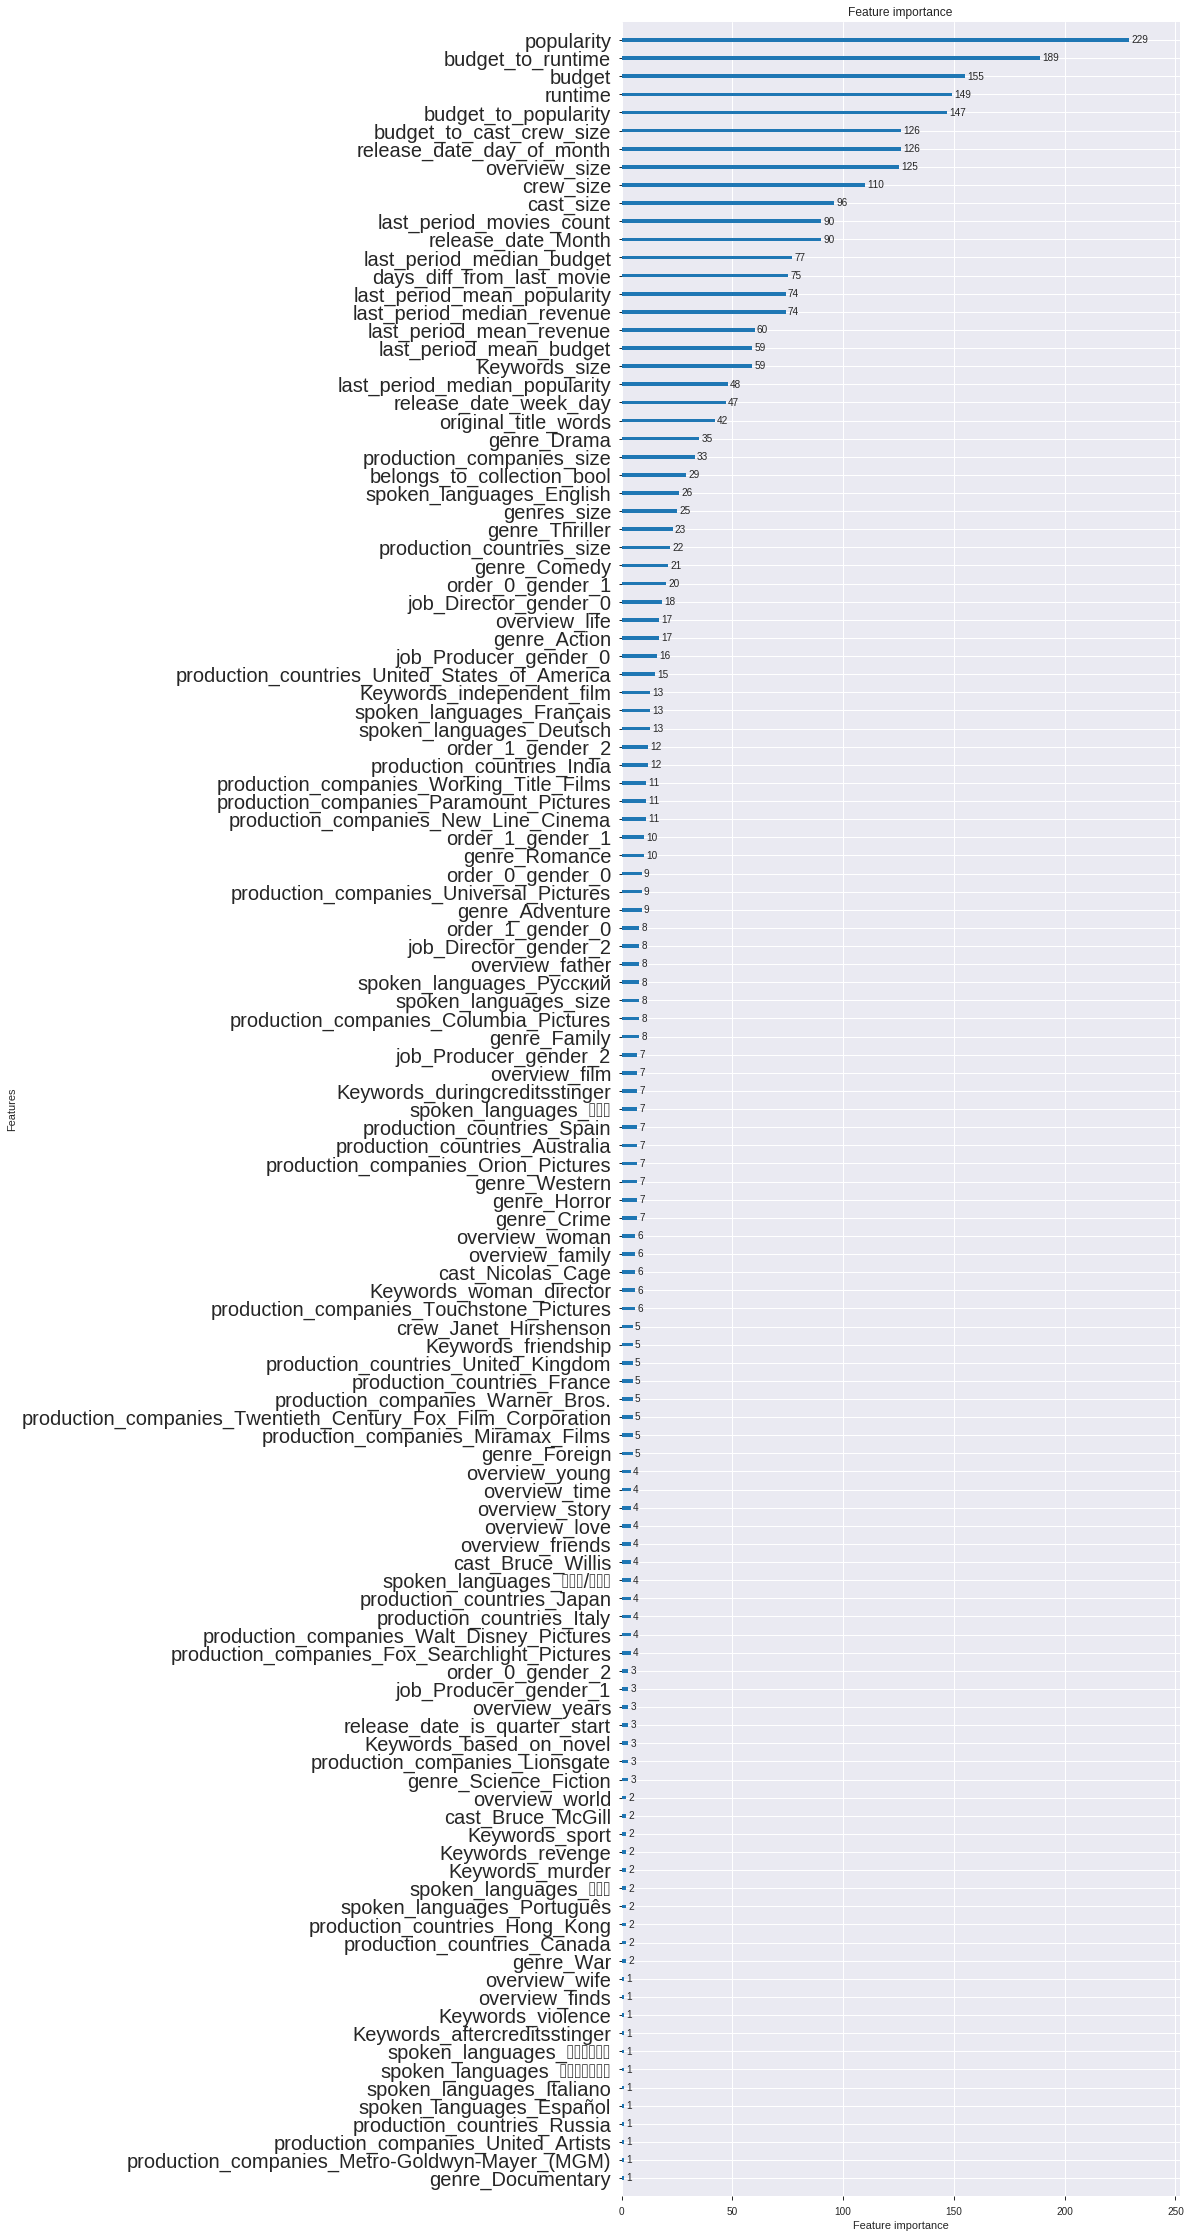

In [0]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.figure(figsize=(20,7))
lgb.plot_importance(model,figsize=(10,40))
plt.yticks(fontsize=20)
plt.show()

Tasks:
1. Build models K folds and hyper params tuning 
2. Features selection
3. Model stacking
